In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup

# Seaborn styling
sns.set(style='white', font_scale=1.5)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

c:\Users\foruf\OneDrive\Desktop\EEP_596\Lab_1_Template\.venv313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
# Create figures directory for saving all plots
import os
FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
print(f"Figures will be saved to: {os.path.abspath(FIGURES_DIR)}")

Figures will be saved to: c:\Users\foruf\OneDrive\Desktop\EEP_596\Lab_1_Template\final_project\figures


In [3]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using CUDA: NVIDIA GeForce RTX 4070 SUPER
Device: cuda


## 2. Data Loading and Exploratory Data Analysis

Dataset: [Kaggle NLP with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data)
- Training samples: 7,613 tweets
- Test samples: 3,263 tweets
- Binary classification: Disaster (1) vs Not Disaster (0)

In [4]:
# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")

# Display sample data
train_df.head()

Training samples: 7613
Test samples: 3263

Columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Class Distribution:
Class 0 (Not Disaster): 4342 (57.0%)
Class 1 (Disaster): 3271 (43.0%)

Class imbalance ratio: 1.33
Saved: figures/01_class_distribution.png


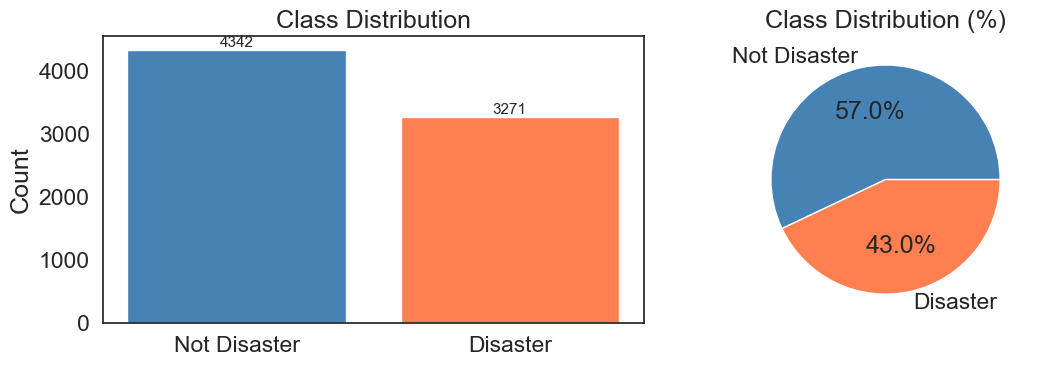

In [5]:
# Class distribution analysis
print("Class Distribution:")
print("="*50)
class_counts = train_df["target"].value_counts()
print(f"Class 0 (Not Disaster): {class_counts[0]} ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"Class 1 (Disaster): {class_counts[1]} ({class_counts[1]/len(train_df)*100:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0] / class_counts[1]:.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bars = axes[0].bar(['Not Disaster', 'Disaster'], [class_counts[0], class_counts[1]], 
                   color=['steelblue', 'coral'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for bar, count in zip(bars, [class_counts[0], class_counts[1]]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{count}', ha='center', fontsize=11)

axes[1].pie([class_counts[0], class_counts[1]], labels=['Not Disaster', 'Disaster'],
            autopct='%1.1f%%', colors=['steelblue', 'coral'])
axes[1].set_title('Class Distribution (%)')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/01_class_distribution.png', dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/01_class_distribution.png")
plt.show()

## 3. Data Preprocessing

Preprocessing steps:
1. Remove URLs (no semantic value)
2. Remove @mentions (usernames not relevant)
3. Preserve hashtag words (contain useful keywords)
4. Clean special characters

In [6]:
def preprocess_tweet(text):
    """Preprocess tweet text for model input."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # Convert hashtags to words
    text = re.sub(r'[^\w\s.,!?]', ' ', text)  # Remove special chars
    text = ' '.join(text.split())  # Clean whitespace
    return text.strip()

# Apply preprocessing
train_df['text_clean'] = train_df['text'].apply(preprocess_tweet)
test_df['text_clean'] = test_df['text'].apply(preprocess_tweet)

# Fill missing values
train_df['keyword'] = train_df['keyword'].fillna('')
train_df['location'] = train_df['location'].fillna('')

# Show examples
print("Preprocessing Examples:")
print("="*80)
for idx in train_df.sample(3, random_state=SEED).index:
    print(f"Original: {train_df.loc[idx, 'text']}")
    print(f"Cleaned:  {train_df.loc[idx, 'text_clean']}")
    print("-"*80)

Preprocessing Examples:
Original: So you have a new weapon that can cause un-imaginable destruction.
Cleaned:  So you have a new weapon that can cause un imaginable destruction.
--------------------------------------------------------------------------------
Original: The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
Cleaned:  The f amp things I do for GISHWHES Just got soaked in a deluge going for pads and tampons. Thx
--------------------------------------------------------------------------------
Original: DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
Cleaned:  DT RT ÛÏThe CoL police can catch a pickpocket in Liverpool Stree...
--------------------------------------------------------------------------------


In [7]:
# Train/Validation Split (80/20, stratified)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text_clean'].tolist(),
    train_df['target'].tolist(),
    test_size=0.2,
    random_state=SEED,
    stratify=train_df['target']
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"\nTraining class distribution: {Counter(train_labels)}")
print(f"Validation class distribution: {Counter(val_labels)}")

Training samples: 6090
Validation samples: 1523

Training class distribution: Counter({0: 3473, 1: 2617})
Validation class distribution: Counter({0: 869, 1: 654})


## 4. Baseline Model: TF-IDF + Logistic Regression

Establish a traditional ML baseline for comparison.

In [8]:
# TF-IDF + Logistic Regression Baseline
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)

baseline_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
baseline_model.fit(X_train_tfidf, train_labels)

baseline_val_preds = baseline_model.predict(X_val_tfidf)

print("="*60)
print("BASELINE MODEL RESULTS (TF-IDF + Logistic Regression)")
print("="*60)
print(f"Validation Accuracy: {(baseline_val_preds == val_labels).mean():.4f}")
print(f"Validation F1 Score: {f1_score(val_labels, baseline_val_preds):.4f}")
print(f"Validation Precision: {precision_score(val_labels, baseline_val_preds):.4f}")
print(f"Validation Recall: {recall_score(val_labels, baseline_val_preds):.4f}")

# Store for comparison
baseline_results = {
    'accuracy': (baseline_val_preds == val_labels).mean(),
    'f1': f1_score(val_labels, baseline_val_preds),
    'precision': precision_score(val_labels, baseline_val_preds),
    'recall': recall_score(val_labels, baseline_val_preds)
}

BASELINE MODEL RESULTS (TF-IDF + Logistic Regression)
Validation Accuracy: 0.8102
Validation F1 Score: 0.7772
Validation Precision: 0.7838
Validation Recall: 0.7706


## 5. Hyperparameter Tuning Summary

conducted 4 systematic experiments to find optimal hyperparameters:

| Experiment | Values Tested | Best Value | Best F1 |
|------------|--------------|------------|--------|
| **Learning Rate** | 1e-5, 2e-5, 3e-5, 5e-5, 1e-4 | **3e-5** | 0.8102 |
| **Dropout** | 0.1, 0.2, 0.3, 0.4, 0.5 | **0.3** | 0.8144 |
| **Batch Size** | 8, 16, 32, 64 | **32** | 0.8094 |
| **Epochs** | 1-10 | **4-5** | 0.8045 |

### Key Findings:
1. **Learning Rate 3e-5** performed best, confirming BERT paper recommendations
2. **Dropout 0.3** provides good regularization without hurting learning
3. **Batch Size 32** balances training stability and speed
4. **Overfitting occurs after epoch 3-4**, early stopping is essential

*Note: Full experiment code is available in the original notebook with detailed logs.*

## 6. DistilBERT Model Implementation

### Why DistilBERT?
- 40% smaller than BERT, 60% faster
- Retains 97% of BERT's performance
- Ideal for short texts like tweets

### Architecture
```
Input Tweet → Tokenizer → DistilBERT → [CLS] token → Custom Head → Classification
                                           ↓
                           768-dim → Dropout → 256-dim → ReLU → Dropout → 2-dim
```

In [9]:
# =============================================================================
# HYPERPARAMETERS (Optimized through experiments)
# =============================================================================
MAX_LENGTH = 128      # Sufficient for tweets (max 280 chars)
BATCH_SIZE = 32       # From Experiment 3
LEARNING_RATE = 3e-5  # From Experiment 1 (best F1=0.8102)
EPOCHS = 5            # From Experiment 4 (converges at epoch 3-5)
WARMUP_STEPS = 200    # Standard for transformers
DROPOUT = 0.3         # From Experiment 2

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print("Hyperparameters (optimized through experiments):")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Dropout: {DROPOUT}")
print(f"  Epochs: {EPOCHS}")

Hyperparameters (optimized through experiments):
  Learning Rate: 3e-05
  Batch Size: 32
  Dropout: 0.3
  Epochs: 5


In [10]:
class DisasterTweetDataset(Dataset):
    """PyTorch Dataset for Disaster Tweets"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = DisasterTweetDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = DisasterTweetDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
print(f"Training dataset: {len(train_dataset)} | Validation dataset: {len(val_dataset)}")

Training dataset: 6090 | Validation dataset: 1523


In [11]:
# Handle class imbalance with weighted sampling and loss
class_counts = Counter(train_labels)
total_samples = len(train_labels)

# Class weights for loss function
weight_0 = total_samples / (2 * class_counts[0])
weight_1 = total_samples / (2 * class_counts[1])
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)
print(f"Class weights: [Not Disaster: {weight_0:.4f}, Disaster: {weight_1:.4f}]")

# Weighted sampler for balanced batches
sample_weights = [1/class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Training batches: {len(train_loader)} | Validation batches: {len(val_loader)}")

Class weights: [Not Disaster: 0.8768, Disaster: 1.1635]
Training batches: 191 | Validation batches: 48


In [12]:
class DisasterTweetClassifier(nn.Module):
    """
    DistilBERT-based classifier with custom classification head.
    Uses [CLS] token representation for sequence classification.
    """
    def __init__(self, num_classes=2, dropout=0.3):
        super(DisasterTweetClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.hidden_size = self.bert.config.hidden_size  # 768
        
        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return self.classifier(cls_output)

# Initialize model
model = DisasterTweetClassifier(num_classes=2, dropout=DROPOUT).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 66,560,258


## 7. Model Training

In [13]:
# Training setup
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, 
                                            num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

print(f"Training Configuration:")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {WARMUP_STEPS}")

Training Configuration:
  Total steps: 955
  Warmup steps: 200


In [14]:
def evaluate_model(model, data_loader, loss_fn):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'loss': total_loss / len(data_loader),
        'accuracy': (np.array(all_preds) == np.array(all_labels)).mean(),
        'f1': f1_score(all_labels, all_preds, average='binary'),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'predictions': all_preds,
        'labels': all_labels
    }

In [15]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': [], 
           'train_acc': [], 'val_acc': []}
best_val_f1 = 0
best_model_state = None

print("Starting Training...")
print("="*70)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds, train_labels_epoch = [], []
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        train_preds.extend(preds)
        train_labels_epoch.extend(labels.cpu().numpy())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(train_labels_epoch, train_preds, average='binary')
    train_acc = (np.array(train_preds) == np.array(train_labels_epoch)).mean()
    val_results = evaluate_model(model, val_loader, loss_fn)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_results['loss'])
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_results['f1'])
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_results['accuracy'])
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val Loss: {val_results['loss']:.4f} | Val F1: {val_results['f1']:.4f}")
    
    if val_results['f1'] > best_val_f1:
        best_val_f1 = val_results['f1']
        best_model_state = model.state_dict().copy()
        print(f"  *** New best model (Val F1: {best_val_f1:.4f}) ***")

print(f"\n{'='*70}")
print(f"Training complete! Best Validation F1: {best_val_f1:.4f}")

Starting Training...


Epoch 1/5: 100%|██████████| 191/191 [00:16<00:00, 11.62it/s, loss=0.3937]



Epoch 1/5
  Train Loss: 0.5512 | Train F1: 0.7148
  Val Loss: 0.4240 | Val F1: 0.7971
  *** New best model (Val F1: 0.7971) ***


Epoch 2/5: 100%|██████████| 191/191 [00:16<00:00, 11.85it/s, loss=0.4553]



Epoch 2/5
  Train Loss: 0.3617 | Train F1: 0.8486
  Val Loss: 0.4263 | Val F1: 0.7994
  *** New best model (Val F1: 0.7994) ***


Epoch 3/5: 100%|██████████| 191/191 [00:16<00:00, 11.82it/s, loss=0.0976]



Epoch 3/5
  Train Loss: 0.2740 | Train F1: 0.8925
  Val Loss: 0.4197 | Val F1: 0.8031
  *** New best model (Val F1: 0.8031) ***


Epoch 4/5: 100%|██████████| 191/191 [00:16<00:00, 11.78it/s, loss=0.1037]



Epoch 4/5
  Train Loss: 0.2093 | Train F1: 0.9247
  Val Loss: 0.4818 | Val F1: 0.7982


Epoch 5/5: 100%|██████████| 191/191 [00:15<00:00, 12.01it/s, loss=0.0304]



Epoch 5/5
  Train Loss: 0.1650 | Train F1: 0.9449
  Val Loss: 0.5158 | Val F1: 0.7922

Training complete! Best Validation F1: 0.8031


## 8. Results and Evaluation

Saved: figures/02_training_curves.png


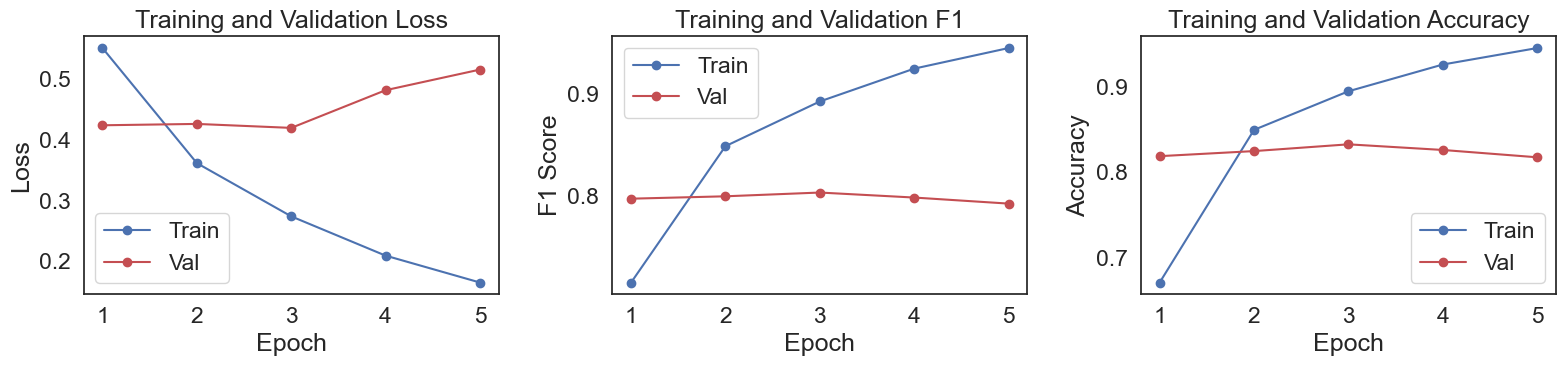

In [16]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
epochs_range = range(1, EPOCHS + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train')
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss'); axes[0].legend()

axes[1].plot(epochs_range, history['train_f1'], 'b-o', label='Train')
axes[1].plot(epochs_range, history['val_f1'], 'r-o', label='Val')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1 Score')
axes[1].set_title('Training and Validation F1'); axes[1].legend()

axes[2].plot(epochs_range, history['train_acc'], 'b-o', label='Train')
axes[2].plot(epochs_range, history['val_acc'], 'r-o', label='Val')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training and Validation Accuracy'); axes[2].legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/02_training_curves.png', dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/02_training_curves.png")
plt.show()

In [17]:
# Load best model and evaluate
model.load_state_dict(best_model_state)
final_results = evaluate_model(model, val_loader, loss_fn)

print("="*60)
print("FINAL MODEL EVALUATION (Best Model)")
print("="*60)
print(f"Validation Accuracy: {final_results['accuracy']:.4f}")
print(f"Validation F1 Score: {final_results['f1']:.4f}")
print(f"Validation Precision: {final_results['precision']:.4f}")
print(f"Validation Recall: {final_results['recall']:.4f}")
print("\nClassification Report:")
print(classification_report(final_results['labels'], final_results['predictions'], 
                          target_names=['Not Disaster', 'Disaster']))

FINAL MODEL EVALUATION (Best Model)
Validation Accuracy: 0.8175
Validation F1 Score: 0.7922
Validation Precision: 0.7749
Validation Recall: 0.8104

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.85      0.82      0.84       869
    Disaster       0.77      0.81      0.79       654

    accuracy                           0.82      1523
   macro avg       0.81      0.82      0.81      1523
weighted avg       0.82      0.82      0.82      1523



Saved: figures/03_confusion_matrix.png


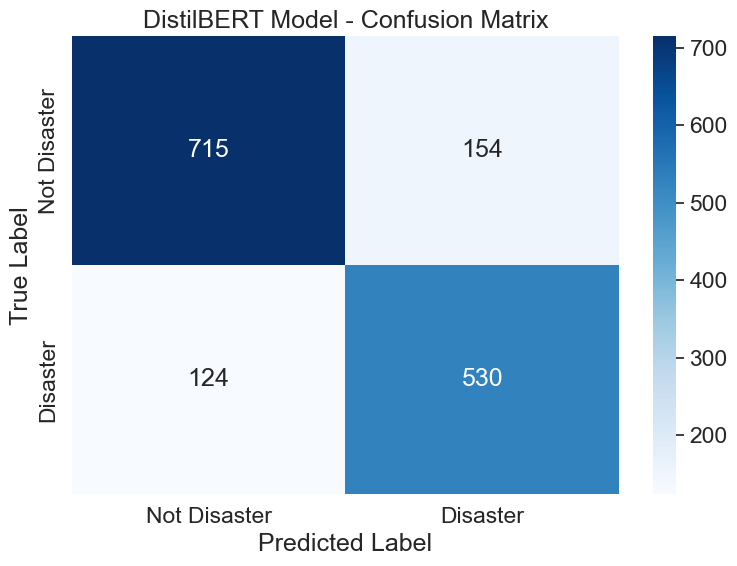

True Negatives: 715 | False Positives: 154
False Negatives: 124 | True Positives: 530


In [18]:
# Confusion Matrix
cm = confusion_matrix(final_results['labels'], final_results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DistilBERT Model - Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/03_confusion_matrix.png', dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/03_confusion_matrix.png")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")

MODEL COMPARISON: Baseline vs DistilBERT
   Metric  Baseline (TF-IDF)  DistilBERT  Improvement  Improvement %
 Accuracy           0.810243    0.817466     0.007223           0.89
 F1 Score           0.777178    0.792227     0.015049           1.94
Precision           0.783826    0.774854    -0.008972          -1.14
   Recall           0.770642    0.810398     0.039755           5.16
Saved: figures/04_model_comparison.png


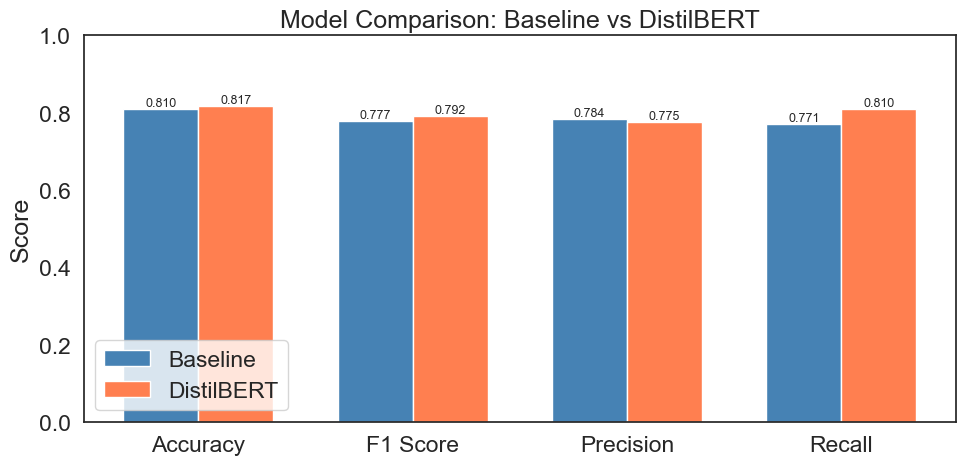

In [19]:
# Model Comparison: Baseline vs DistilBERT
distilbert_results = {
    'accuracy': final_results['accuracy'],
    'f1': final_results['f1'],
    'precision': final_results['precision'],
    'recall': final_results['recall']
}

print("="*70)
print("MODEL COMPARISON: Baseline vs DistilBERT")
print("="*70)
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Baseline (TF-IDF)': [baseline_results['accuracy'], baseline_results['f1'], 
                          baseline_results['precision'], baseline_results['recall']],
    'DistilBERT': [distilbert_results['accuracy'], distilbert_results['f1'],
                   distilbert_results['precision'], distilbert_results['recall']]
})
comparison_df['Improvement'] = comparison_df['DistilBERT'] - comparison_df['Baseline (TF-IDF)']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline (TF-IDF)'] * 100).round(2)
print(comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(4)
width = 0.35
bars1 = ax.bar(x - width/2, [baseline_results['accuracy'], baseline_results['f1'],
                             baseline_results['precision'], baseline_results['recall']], 
               width, label='Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, [distilbert_results['accuracy'], distilbert_results['f1'],
                             distilbert_results['precision'], distilbert_results['recall']], 
               width, label='DistilBERT', color='coral')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Baseline vs DistilBERT')
ax.set_xticks(x)
ax.set_xticklabels(['Accuracy', 'F1 Score', 'Precision', 'Recall'])
ax.legend()
ax.set_ylim(0, 1)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
            ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/04_model_comparison.png', dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/04_model_comparison.png")
plt.show()

In [20]:
# Inference examples
test_tweets = [
    "BREAKING: Massive earthquake hits California, buildings collapsed",
    "Just watched a disaster movie, it was so good!",
    "Forest fire spreading rapidly in Oregon, evacuations ordered",
    "My kitchen is a war zone after cooking dinner",
    "Tsunami warning issued for coastal areas after underwater earthquake"
]

print("="*70)
print("INFERENCE EXAMPLES")
print("="*70)

model.eval()
for tweet in test_tweets:
    clean_tweet = preprocess_tweet(tweet)
    encoding = tokenizer(clean_tweet, padding='max_length', truncation=True, 
                        max_length=MAX_LENGTH, return_tensors='pt')
    
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).item()
        confidence = probs[0][pred].item()
    
    label = "DISASTER" if pred == 1 else "NOT DISASTER"
    print(f"\nTweet: {tweet}")
    print(f"Prediction: {label} (Confidence: {confidence:.1%})")

INFERENCE EXAMPLES

Tweet: BREAKING: Massive earthquake hits California, buildings collapsed
Prediction: DISASTER (Confidence: 99.6%)

Tweet: Just watched a disaster movie, it was so good!
Prediction: NOT DISASTER (Confidence: 89.7%)

Tweet: Forest fire spreading rapidly in Oregon, evacuations ordered
Prediction: DISASTER (Confidence: 99.6%)

Tweet: My kitchen is a war zone after cooking dinner
Prediction: NOT DISASTER (Confidence: 97.2%)

Tweet: Tsunami warning issued for coastal areas after underwater earthquake
Prediction: DISASTER (Confidence: 99.6%)


In [21]:
# Save model
import os
os.makedirs("models", exist_ok=True)
torch.save(best_model_state, 'models/disaster_tweet_classifier.pt')
print("Model saved to 'models/disaster_tweet_classifier.pt'")

Model saved to 'models/disaster_tweet_classifier.pt'
